In [2]:
from utils import load_buffers,load_task_markers
import pandas as pd
import config
import os
import numpy as np

import mne
from mne import create_info
from mne.epochs import EpochsArray
from mne.decoding import Vectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot as plt

import pickle
%matplotlib qt

In [3]:
# def collate_data(main_folder):
#     all_task_data = []
#     all_signal_data = []
#     session_number = 1
#     
#     for sub_dir in os.listdir(main_folder):
#         sub_dir_path = os.path.join(main_folder, sub_dir)
#         if os.path.isdir(sub_dir_path):
#             task_data_path = os.path.join(sub_dir_path, 'task_data', 'task_markers.npz')
#             signal_data_folder = os.path.join(sub_dir_path, 'signal_data')
#             
#             if os.path.exists(task_data_path) and os.path.exists(signal_data_folder):
#                 df_tasks = load_task_markers(task_data_path)
#                 df_buffers = load_buffers(signal_data_folder)
#                 
#                 # Add session_number column
#                 df_tasks['session_number'] = session_number
#                 df_buffers['session_number'] = session_number
#                 
#                 all_task_data.append(df_tasks)
#                 all_signal_data.append(df_buffers)
#                 
#                 session_number += 1
#     
#     if all_task_data:
#         combined_tasks = pd.concat(all_task_data, ignore_index=True)
#         combined_tasks = combined_tasks.sort_values('timestamps').reset_index(drop=True)
#     else:
#         combined_tasks = pd.DataFrame()
#     
#     if all_signal_data:
#         combined_buffers = pd.concat(all_signal_data, ignore_index=True)
#         combined_buffers = combined_buffers.sort_values('timestamps').reset_index(drop=True)
#     else:
#         combined_buffers = pd.DataFrame()
#     
#     return combined_tasks, combined_buffers

In [4]:
# # Define the main folder path
# main_folder_path = 'processed_data/motor_imagery/'
# 
# # Collate the data
# df_tasks, df_buffers = collate_data(main_folder_path)

In [5]:
# df_buffers

In [6]:
# load the task and signal files stored in the disk
# Based on the task timestamps, subset the signals and annotate the events
# create epoch data that includes the signal and events
# use the epoch data to train a classifier
# save the classifier model as a pickle file for prediction later

# Load the .npz file for task
file_path = 'processed_data/motor_imagery/2024-06-15_14-30-34/task_data/task_markers.npz'  # Replace with your file path
df_tasks = load_task_markers(file_path)

# Load the .npz file for buffer
folder_path = 'processed_data/motor_imagery/2024-06-15_14-30-34/signal_data/'
df_buffers = load_buffers(folder_path)

# print(df_buffers)
print("Reading signals and markers from signals from disk...")

df_buffers = df_buffers.sort_values('timestamps').reset_index(drop=True)
df_tasks = df_tasks.sort_values('timestamps').reset_index(drop=True)

Array names in the .npz file: ['event_ids', 'timestamps']
Reading signals and markers from signals from disk...


In [7]:
# df_buffers.describe()

In [8]:
df_buffers_raw = df_buffers.iloc[:,:config.device_details['relevant_channels_from_device']] 
# df_buffers_raw = df_buffers_raw * 1e-6

channel_names = config.device_details['channels']
df_buffers_raw.columns = channel_names

In [9]:
# df_buffers_raw

In [10]:
# df_buffers_raw
info = mne.create_info(
        ch_names=channel_names,
        sfreq=config.device_details['sfreq'],  # Assuming the data is sampled at 1 Hz; adjust as necessary
        # change this for different electrode configuration
        ch_types=['eeg'] * len(channel_names))

raw = mne.io.RawArray(df_buffers_raw[channel_names].values.T, info)
raw.info

Creating RawArray with float64 data, n_channels=8, n_times=4500
    Range : 0 ... 4499 =      0.000 ...    17.996 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [26]:
df = pd.DataFrame(raw.get_data().T)
df.to_csv("unicorn_sample", index=False)

In [11]:
# raw.info[]

In [12]:
df_markers = df_tasks[df_tasks['event_ids'].isin([1,2,3,4,99,100])]

markers_map = {
            1 :'left_start',
            2: 'left_end',
            3:'right_start',
            4:'right_end',
            99:'rest_start',
            100:'rest_end'
}

In [13]:
# Initialize lists for onsets, durations, and descriptions
onsets = []
durations = []
descriptions = []

# Create a dictionary to keep track of start times
start_times = {}

# Iterate over the DataFrame rows
for index, row in df_markers.iterrows():
    event_id = row['event_ids']
    timestamp = row['timestamps']

    if event_id in markers_map:
        description = markers_map[event_id]

        # Check if it is a start event
        if 'start' in description:
            # Store the start time
            start_times[description.split('_')[0]] = timestamp
        elif 'end' in description:
            # Determine the corresponding start event type
            event_type = description.split('_')[0]  # e.g., 'left', 'right', 'rest'
            
            if event_type in start_times:
                start_time = start_times[event_type]
                duration = timestamp - start_time
                
                # Append to lists
                onsets.append(start_time)
                durations.append(duration)
                descriptions.append(event_type.upper())
                # Remove the start time to avoid re-use
                del start_times[event_type]

# Print the results
print("Onsets:", onsets)
print("Durations:", durations)
print("Descriptions:", descriptions)

Onsets: [168762.4440554, 168763.953997, 168764.9544988, 168766.4692759, 168767.4697606, 168768.9886886, 168769.9897843, 168771.5011534, 168772.5017235, 168774.0173105, 168775.0178167, 168776.5354233]
Durations: [1.5098081000032835, 1.0004895000020042, 1.5146895999787375, 1.0004541000234894, 1.5188402999774553, 1.0010550000006333, 1.5112194999819621, 1.0005458999949042, 1.5155144000018481, 1.0004835999861825, 1.517496199987363, 1.0002925000153482]
Descriptions: ['LEFT', 'REST', 'RIGHT', 'REST', 'LEFT', 'REST', 'RIGHT', 'REST', 'LEFT', 'REST', 'RIGHT', 'REST']


In [14]:
onsets = onsets - df_buffers['timestamps'][0]

In [15]:
# onsets

In [16]:
raw_annot = mne.Annotations(onset=onsets, duration=durations, orig_time= None,description=descriptions)
print(raw_annot)
raw.set_annotations(raw_annot)

raw.set_montage('easycap-M1')

<Annotations | 12 segments: LEFT (3), REST (6), RIGHT (3)>


C:\Users\iamth\AppData\Local\Temp\ipykernel_16640\3743205479.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(raw_annot)


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [19]:
raw.save('unicorn_raw.fif')

Writing C:\Users\iamth\Desktop\Obsidian Sync\NEvol-project\unicorn_raw.fif
Closing C:\Users\iamth\Desktop\Obsidian Sync\NEvol-project\unicorn_raw.fif
[done]


In [20]:
mne.io.read_raw_fif('unicorn_raw.fif')

Opening raw data file unicorn_raw.fif...
    Range : 0 ... 4499 =      0.000 ...    17.996 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [18]:
raw_events, raw_events_mapping = mne.events_from_annotations(raw)

Used Annotations descriptions: ['LEFT', 'REST', 'RIGHT']


In [19]:
# raw_events

In [20]:
fig = mne.viz.plot_events(
    raw_events, sfreq=raw.info["sfreq"], first_samp=raw.first_samp, event_id=raw_events_mapping
)

In [68]:
# raw.get_data()

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


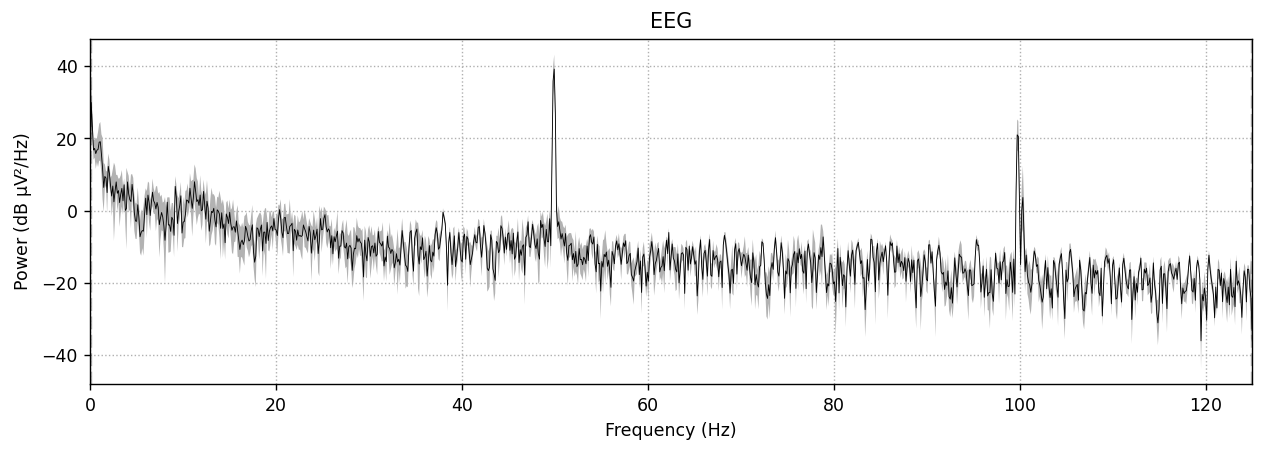

In [21]:
spectrum = raw.compute_psd()
spectrum.plot(average=True, picks="data", exclude="bads", amplitude=False)

In [70]:
# raw.plot(block=True)

In [71]:
# midline = ["EEG 002", "EEG 012", "EEG 030", "EEG 048", "EEG 058", "EEG 060"]
# spectrum.plot(picks="all", exclude="bads", amplitude=False)

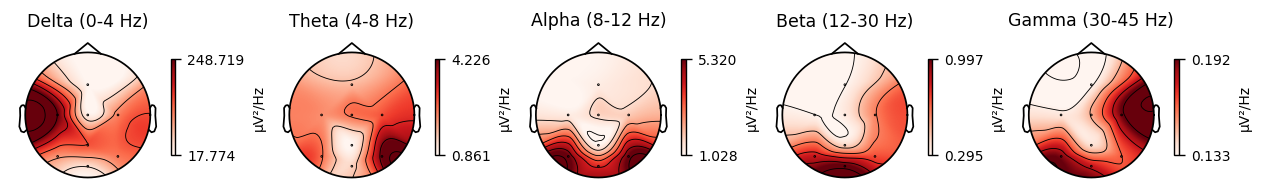

In [92]:
spectrum.plot_topomap()

In [73]:
# spectrum.plot_topo()

In [74]:
# raw.plot_sensors(ch_type="eeg")

In [75]:
# raw.plot_projs_topomap(colorbar=True)

In [22]:
epochs = mne.Epochs(raw, raw_events, raw_events_mapping, tmin=-0.1, tmax=1.5,
                    baseline=(None, 0), preload=True)

Not setting metadata
12 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 401 original time points ...
1 bad epochs dropped


In [77]:
# epochs['LEFT']

In [23]:
ev_left = epochs['LEFT'].average()
ev_right = epochs['RIGHT'].average()

In [29]:
f, axs = plt.subplots(1, 2, figsize=(10, 5))
_ = f.suptitle('Left / Right Imagery', fontsize=20)
_ = ev_left.plot(axes=axs[0], show=True, time_unit='s')
_ = ev_right.plot(axes=axs[1], show=False, time_unit='s')

plt.show()
# plt.tight_layout()

In [24]:
X = epochs.get_data(copy=False)  # Shape: (n_epochs, n_channels, n_times)
y = epochs.events[:, 2]  # Shape: (n_epochs,)

In [28]:
X[0]

array([[-6.01209435e-05,  5.71139198e-05,  1.13373197e-04, ...,
         6.16288123e-05, -6.73628869e-05, -1.29165621e-04],
       [-7.08975361e-05, -4.00303486e-05,  5.79579327e-05, ...,
         6.18954327e-05,  5.27743389e-05, -2.72686298e-05],
       [ 1.31017127e-05,  2.07013221e-05, -2.15877404e-05, ...,
        -3.78377404e-05, -3.42615685e-05, -4.19906851e-06],
       ...,
       [ 2.93373648e-05,  6.22603666e-06, -3.14360727e-05, ...,
        -4.66352915e-05,  3.92330228e-06,  3.85912710e-05],
       [ 3.12780762e-05,  1.20550537e-04,  3.99055176e-05, ...,
        -9.64819336e-06, -1.32448486e-04, -5.99172363e-05],
       [ 6.48903245e-06,  4.10437200e-05,  8.56715745e-06, ...,
        -3.97336238e-05, -7.04914363e-05, -3.57101863e-05]])

In [ ]:
X

In [26]:
y.shape

(11,)

In [63]:
# epochs['LEFT'].plot_image()
# epochs['RIGHT'].plot_image()

In [97]:
mne.viz.plot_epochs_image(epochs['LEFT'],title="Left Imagery",colorbar=True)
mne.viz.plot_epochs_image(epochs['RIGHT'],title="Right Imagery",colorbar=True)

Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
combining channels using GFP (eeg channels)
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
combining channels using GFP (eeg channels)


[<Figure size 800x600 with 3 Axes>]

In [98]:
# Reshape the data to (n_samples, n_features)
X = X.reshape(len(X), -1)

# Create and train a classifier
clf = make_pipeline(Vectorizer(), RandomForestClassifier(n_estimators=100))
clf.fit(X, y)

Pipeline(steps=[('vectorizer',
                 <mne.decoding.transformer.Vectorizer object at 0x0000023CD1B83BB0>),
                ('randomforestclassifier', RandomForestClassifier())])

In [30]:
test_index = 0  # Use the first training data point for prediction
test_sample = X[test_index].reshape(1, -1)  # Reshape to (1, n_features)
predicted_label = clf.predict(test_sample)
actual_label = y[test_index]
print(f"Predicted label: {predicted_label[0]}, Actual label: {actual_label}")

NameError: name 'clf' is not defined

In [100]:
# Save the model as a pickle file
with open('classifier_model.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [57]:
# -----------------------Evoked-----------------------------------------------------------------------------------------

In [33]:
# root = mne.datasets.sample.data_path() / "MEG" / "sample"
# evoked_file = root / "sample_audvis-ave.fif"
# evokeds_list = mne.read_evokeds(
#     evoked_file, baseline=(None, 0), proj=True, verbose=False
# )
# 
# # Show condition names and baseline intervals
# for e in evokeds_list:
#     print(f"Condition: {e.comment}, baseline: {e.baseline}")
#     
# conds = ("aud/left", "aud/right", "vis/left", "vis/right")
# evks = dict(zip(conds, evokeds_list))

In [35]:
# evoked_file

In [34]:
# evks

In [36]:
# ------------------------------------------ Old code for creating epochs directly

In [37]:
# # Perform an as of merge to find the closest earlier and later event_id
# df_buffers['prev_event_id'] = pd.merge_asof(df_buffers, df_tasks,
#                                             left_on='timestamps', right_on='timestamps',
#                                             direction='backward')['event_ids']
# 
# df_buffers['next_event_id'] = pd.merge_asof(df_buffers, df_tasks,
#                                             left_on='timestamps', right_on='timestamps',
#                                             direction='forward')['event_ids']
# 
# markers = {
#     'left_start': [1],
#     'left_end': [2],
#     'right_start': [3],
#     'right_end': [4],
#     'rest_start': [99],
#     'rest_end': [100],
#     'task_start': [-1],
#     'task_end': [-2]
# }
# 
# def determine_phase(row):
#     if row['prev_event_id'] in markers['left_start'] and row['next_event_id'] in markers['left_end']:
#         return 'left'
#     elif row['prev_event_id'] in markers['right_start'] and row['next_event_id'] in markers['right_end']:
#         return 'right'
#     elif row['prev_event_id'] in markers['rest_start'] and row['next_event_id'] in markers['rest_end']:
#         return 'rest'
#     else:
#         return 'unknown'
# 
# df_buffers['phase'] = df_buffers.apply(determine_phase, axis=1)
# 
# grouped = df_buffers.groupby(['part_number', 'phase']).size().reset_index(name='count')
# 
# sfreq = config.device_details['sfreq']
# buffer_duration = config.epoch_information['duration']
# 
# valid_phases = ['left', 'right', 'rest']


In [38]:
# df_buffers_filt = df_buffers[df_buffers['phase'].apply(lambda x: any(item in x for item in valid_phases))]

In [39]:
# df_buffers_filt.loc[:,'phase_group'] = (df_buffers_filt['phase'] != df_buffers_filt['phase'].shift()).cumsum()

In [40]:
# df_phase_map = df_buffers_filt[['phase_group', 'phase']].drop_duplicates()

In [41]:
# df_buffers_filt

In [42]:
# def get_phase_name(phase_group_number):
#     # Look up the phase group number in the DataFrame
#     phase_name = df_phase_map.loc[df_phase_map['phase_group'] == phase_group_number, 'phase']
#     
#     # Check if the phase group number exists in the DataFrame
#     if not phase_name.empty:
#         return phase_name.values[0]
#     else:
#         return "Invalid phase group number"

In [43]:
# val_sel_columns = config.device_details['relevant_channels_from_device']
# columns_to_select = df_buffers.columns[:val_sel_columns].tolist() + ['part_number', 'timestamps', 'phase', 'phase_group']
# df_buffers_filt = df_buffers_filt[columns_to_select]

In [45]:
# rename_dict = {old_name: new_name for old_name, new_name in zip(df_buffers_filt.columns[:val_sel_columns], channel_names)}
# df_buffers_renamed = df_buffers_filt.rename(columns=rename_dict)

In [46]:
# df_buffers_renamed[channel_names] = df_buffers_renamed[channel_names].values * 1e-6

In [47]:
# df_tasks

In [48]:
# df_buffers_renamed

In [ ]:
# # Creating epochs data
# epochs_data = []
# events = []
# 
# event_id = {'left': 1, 'right': 2, 'rest': 3}
# phases = ['left', 'right', 'rest']

In [ ]:
max_shape = 0  # Initialize maximum shape

for i, df_phase_group in df_buffers_renamed.groupby('phase_group'):
    if get_phase_name(i) not in phases:
        continue
    data_array = df_phase_group[channel_names].values.T
    max_shape = max(max_shape, data_array.shape[1])
    epochs_data.append(data_array)
    
    phase_group = df_phase_group['phase_group'].iloc[0]
    phase = df_phase_map[df_phase_map['phase_group'] == phase_group]['phase'].iloc[0]
    event = event_id[phase]
    
    events.append([len(epochs_data) - 1, 0, event])

In [ ]:
events = np.array(events)

In [ ]:
events

In [49]:
# # Pad or truncate each epoch's data to match the maximum shape
# for i, data_array in enumerate(epochs_data):
#     current_shape = data_array.shape[1]
#     if current_shape < max_shape:
#         padding = ((0, 0), (0, max_shape - current_shape))
#         epochs_data[i] = np.pad(data_array, padding, mode='constant')
#     elif current_shape > max_shape:
#         epochs_data[i] = data_array[:, :max_shape]
# 
# # Convert epoch_data to numpy array
# epochs_data = np.array(epochs_data)
# 
# # Print the shape of epoch_data
# print("Shape of epoch_data:", epochs_data.shape)

In [50]:
# # Create MNE info structure
# info = create_info(ch_names=channel_names, sfreq=config.device_details['sfreq'], ch_types='eeg')
# 
# # Create MNE Epochs object
# epochs = EpochsArray(epochs_data, info, events, event_id=event_id, tmin=0)

In [ ]:
# X
# y

